In [1]:
from numpy import *
from scipy.integrate import odeint
from cosmo import * 
from TLA   import *
import matplotlib.pyplot as plt
%matplotlib inline

# Three-Level Atom Integration

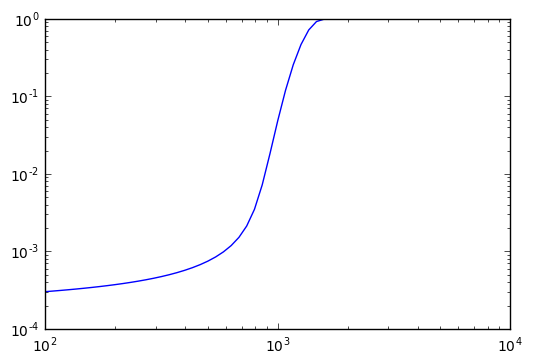

In [2]:
def getfz():
    def fzHIon(rs):
        return 0
    def fzHeIon(rs):
        return 0
    def fzHLya(rs):
        return 0
    def fzHeat(rs):
        return 0
    return {'HIon':fzHIon, 'HeIon':fzHeIon, 'HLya':fzHLya, 'Heat':fzHeat}

def getinjrate():
    def injrate(rs): 
        return 0
    return injrate

initrs = 2000
initCond = [TCMB(initrs), 5]

p = getTLADE(getfz(),getinjrate())

rsVec = flipud(logspace(2,log10(initrs), num=40))

a = odeint(p,initCond,rsVec)
plt.plot(rsVec,0.5+0.5*tanh(a[:,1]),'b',label='theta(t)')
plt.xscale('log')
plt.yscale('log')

plt.show()